# Parameter estimation from Sensor Results

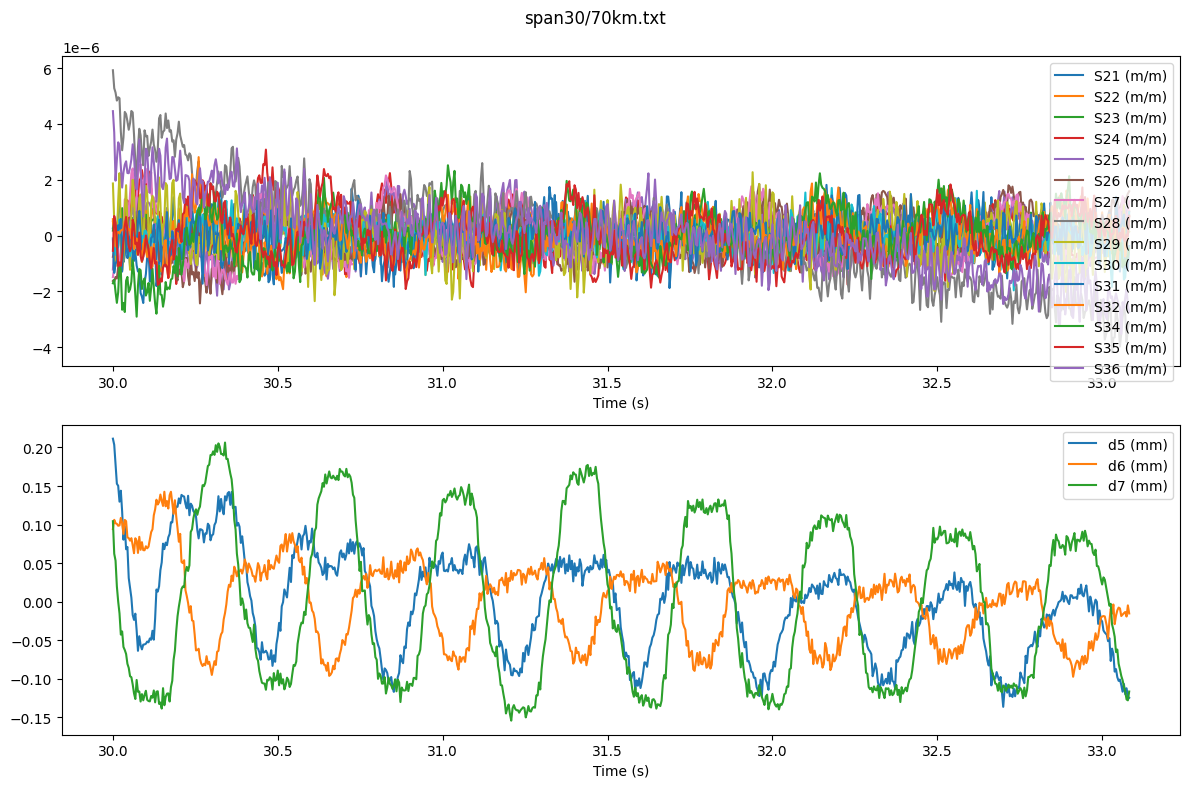

In [23]:
# Opening sensor result files
import pandas as pd
import matplotlib.pyplot as plt

def getLLDataFromFile(_FILENAME, _filterStrainRegex='', _filterDispRegex='', _startTime=0, _endTime=100000, _filterStartTime=0, _filterEndTime=10) -> pd.DataFrame:
  _dfSensorRaw = pd.read_csv(_FILENAME, sep='\t')
  _dfSensorRaw["Time"] = _dfSensorRaw["Time"].apply(pd.to_timedelta)
  _dfSensorRaw["Time"] = (_dfSensorRaw["Time"] - _dfSensorRaw["Time"].min()).dt.total_seconds()
  _dfSensorRaw = _dfSensorRaw.set_index("Time")
  _dfSensorRaw.index.name = "Time (s)"
  _dfSensorRaw = _dfSensorRaw.filter(regex='^[Sd]')
  if _filterStrainRegex != '':
    _dfSensorRaw = _dfSensorRaw.filter(regex=_filterStrainRegex)
  if _filterDispRegex != '':
    _dfSensorRaw = _dfSensorRaw.filter(regex=_filterDispRegex)
  
  # removing the constant value using filterStartTime and filterEndTime
  _dfSensorRaw = _dfSensorRaw - _dfSensorRaw.iloc[(_dfSensorRaw.index>=_filterStartTime) & (_dfSensorRaw.index<=_filterEndTime)].mean()

  # Trimming outside startTime and endTime
  _dfSensorRaw = _dfSensorRaw[(_dfSensorRaw.index>=_startTime) & (_dfSensorRaw.index<=_endTime)]
  
  # Setting up for plotting
  _fig, (_ax1, _ax2) = plt.subplots(2,1,figsize=(12,8), layout='tight')
  _fig.suptitle(_FILENAME)
  
  # Extracing results of strains from sensors
  _dfSensorRaw.filter(regex='^S').plot(ax=_ax1)
  _ax1.legend(loc="upper right")

  # Extracing results of displacements from sensors
  _dfSensorRaw.filter(regex='^d').plot(ax=_ax2)
  _ax2.legend(loc="upper right")

  return _dfSensorRaw

#Span30
dfSensor = getLLDataFromFile('span30/70km.txt', _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _startTime=30, _endTime=1000, _filterStartTime=30, _filterEndTime=1000)

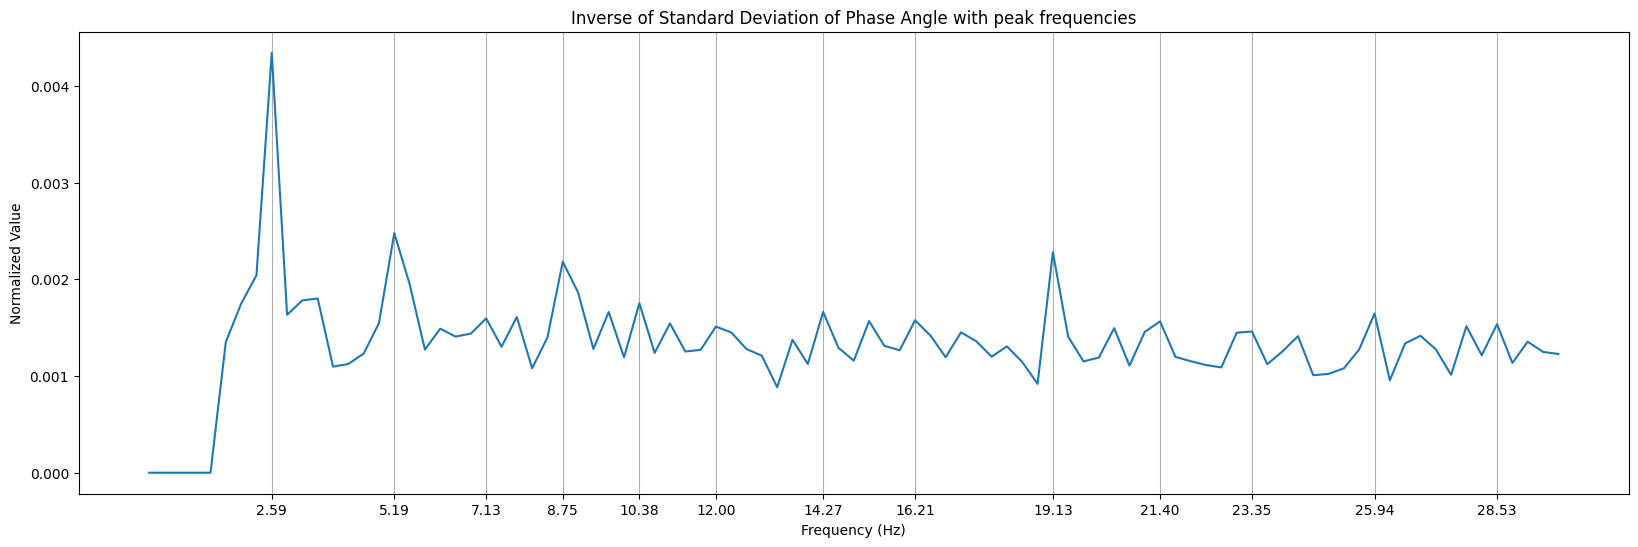

array([ 2.59403372,  5.18806744,  7.13359274,  8.75486381, 10.37613489,
       11.99740597, 14.26718547, 16.21271077, 19.1309987 , 21.40077821,
       23.3463035 , 25.94033722, 28.53437095])

In [20]:
# Calculating Inverse of Phase Angle
import math
import pandas as pd
import numpy as np
from scipy import fft, signal
import matplotlib.pyplot as plt

def calculateInversePhase(_dfSensor:pd.DataFrame, _ignoreTillFreq:float=2, _maxFreq:float=30):
  _EPS = np.finfo(float).eps
  _phi = []
  _phi_norm = []
  _disp = []
  _fps = 1/(_dfSensor.index[1] - _dfSensor.index[0])

  for __index, __column in enumerate(_dfSensor.columns):
    __response = _dfSensor[__column].to_numpy()
    __responseFFT = fft.rfft(__response)
    _disp.append(np.abs(__responseFFT))
    _phi.append([math.atan2(_.imag, _.real) for _ in __responseFFT])
    _phi_norm.append([math.atan(_) for _ in (__responseFFT.real/(__responseFFT.imag+_EPS))])
  
  _disp = np.array(_disp)
  _phi = np.array(_phi)
  _phi_norm = np.array(_phi_norm)

  _freqs = fft.rfftfreq(_dfSensor.shape[0], 1/_fps)
  _inversePhaseAngleSD = 1/_phi_norm.std(axis=0)
  _inversePhaseAngleSD = _inversePhaseAngleSD/_inversePhaseAngleSD.max()
  _inversePhaseAngleSD[_freqs<_ignoreTillFreq] = 0

  # Only keeping till the frequency required
  _freqs, _inversePhaseAngleSD = _freqs[_freqs<_maxFreq], _inversePhaseAngleSD[_freqs<_maxFreq]
  _peaks, _ = signal.find_peaks(_inversePhaseAngleSD, distance=5)

  plt.figure(figsize=((20,6)))
  plt.plot(_freqs, _inversePhaseAngleSD)
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Normalized Value")
  plt.title("Inverse of Standard Deviation of Phase Angle with peak frequencies")
  plt.xticks(list(_freqs[_peaks]), [f"{_freqs[__peak]:.2f}" for __peak in _peaks])
  plt.grid(axis='x')
  plt.show()
  return _freqs[_peaks]
  
calculateInversePhase(dfSensor.filter(regex="^S"), 1.5)

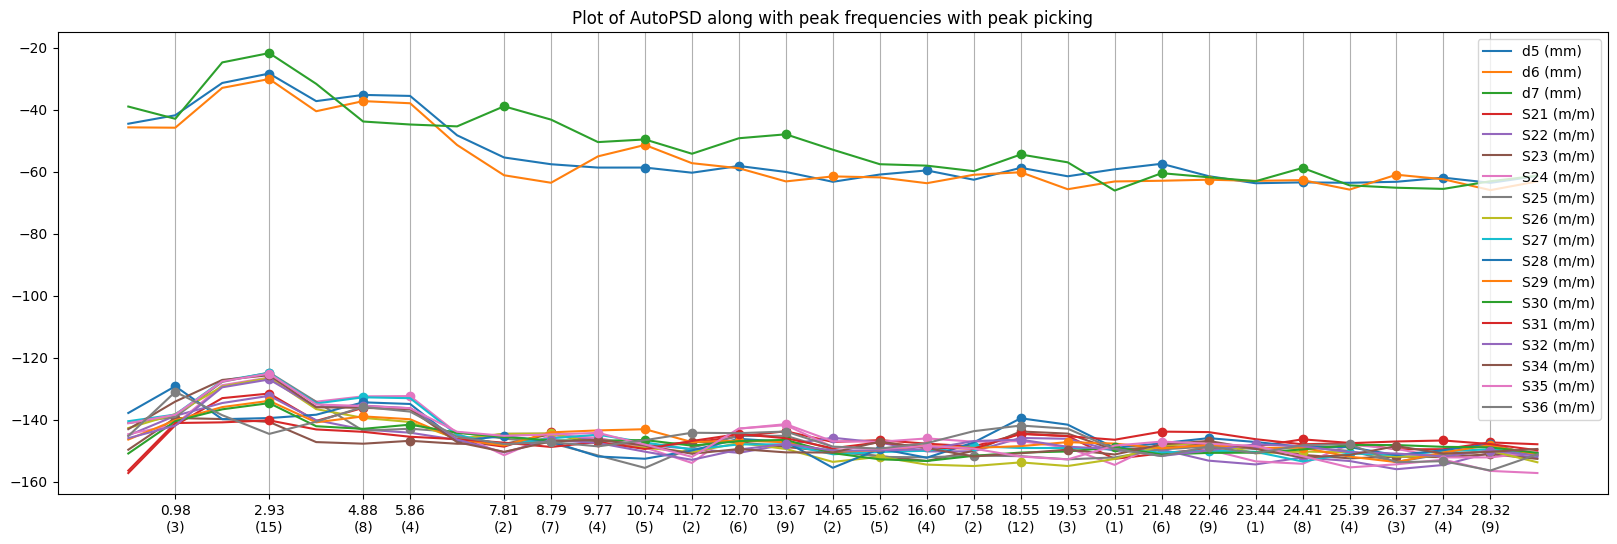

In [2]:
# Plotting AutoPSD and finding peak frequencies
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def getAutoPSD(_dfSensor:pd.DataFrame):
  _fps = 1/(_dfSensor.index[1] - _dfSensor.index[0])
  _freqs, _AutoPSDs = signal.welch(_dfSensor.to_numpy().T, _fps)
  _AutoPSDs = 10*np.log10(_AutoPSDs)
  _freqs, _AutoPSDs = _freqs[_freqs<30], _AutoPSDs[:,_freqs<30]
  return _freqs, _AutoPSDs

def getPeakFrequenciesAndCount(_freqs, _AutoPSDs):
  _freqCountDict = {}
  def updateCountDict(__countDict:dict[float,int], __values:list[float])->None:
    for ___value in __values:
      if not ___value in __countDict.keys():
        __countDict[___value] = 0
      __countDict[___value] += 1
  _freqPeaks = []
  _AutoPSDPeaks = []
  for __AutoPSD in _AutoPSDs:
    __peaks, _ = signal.find_peaks(__AutoPSD)
    _freqPeaks.append([_freqs[peak] for peak in __peaks])
    _AutoPSDPeaks.append([__AutoPSD[peak] for peak in __peaks])
    updateCountDict(_freqCountDict, _freqPeaks[-1])
  _freqCountDict = {freq:_freqCountDict[freq] for freq in sorted(_freqCountDict.keys())}
  return _freqPeaks, _AutoPSDPeaks, _freqCountDict

def plotAutoPSDandGetPeakCount(_dfSensor):
  plt.figure(figsize=((20, 6)))
  _freqs, _AutoPSDs = getAutoPSD(_dfSensor)
  _freqPeaks, _AutoPSDPeaks, _freqCountDict = getPeakFrequenciesAndCount(_freqs, _AutoPSDs)

  for __name, __AutoPSD, __freqPeak, __AutoPSDPeak in zip(_dfSensor.columns, _AutoPSDs, _freqPeaks, _AutoPSDPeaks):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(_freqs, __AutoPSD, label=__name, color=color)
    plt.plot(__freqPeak, __AutoPSDPeak, 'o', color=color)
  plt.title(f"Plot of AutoPSD along with peak frequencies with peak picking")
  plt.xticks(list(_freqCountDict.keys()), [f"{__key:.2f}\n({__value})" for __key, __value in _freqCountDict.items()])
  plt.grid(axis='x')
  plt.legend()
  plt.show()
  return _freqCountDict

peakFrequencies = list(plotAutoPSDandGetPeakCount(dfSensor).keys())

Optimization terminated successfully.
         Current function value: 0.178819
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 0.163885
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 0.151686
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 0.151235
         Iterations: 40
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 0.149660
         Iterations: 98
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: 0.149651
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 0.149649
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfu

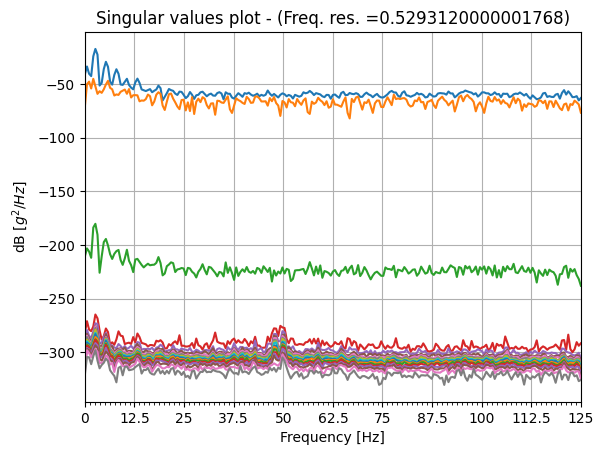

In [3]:
# Getting mode shapes using all responses
from ModalParameterList import ModalParameterList, ModalParameterListEncoder
import numpy as np

sourceAll = dfSensor.columns[0]
initialOmegasAllResults = list(2*np.pi*np.array(peakFrequencies))
initialZetasAllResults = [0.01] * len(initialOmegasAllResults)
parametersAllResults = ModalParameterList(initialOmegasAllResults, initialZetasAllResults, dfSensor, sourceAll)
parametersAllResults.optimize(20)
print("Initial Peak Frequencies")
print(peakFrequencies)
print("Natural Frequencies (rad/s):")
print(parametersAllResults.omegas)
print("Natural Frequencies (Hz):")
print([_/2/np.pi for _ in parametersAllResults.omegas])
print("Damping Ratio:")
print(parametersAllResults.zetas)
print("Mode Shapes:")
print(parametersAllResults.modeShapes)
with open('DataExchange/.AllResults.json', 'w') as f:
  f.write(ModalParameterListEncoder().encode(parametersAllResults))

In [36]:
# Saving results in csv format to 
finalResults = parametersAllResults.modeShapes
finalResults.loc["Initial Search Frequencies"] = peakFrequencies
finalResults.loc["Frequencies"] = [_/2/np.pi for _ in parametersAllResults.omegas]
finalResults.loc["Omegas"] = parametersAllResults.omegas
finalResults.loc["Zetas"] = parametersAllResults.zetas
finalResults.to_csv('DataExchange/.AllResults.csv')
finalResults

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
d5 (mm),6.604256e-01,4.477115e-01,1.000000e+00,1.000000e+00,-1.873024e-02,1.599283e-01,6.059599e-02,5.019027e-02,2.891208e-01,0.206387,...,9.496121e-03,3.019957e-01,9.496121e-03,9.496121e-03,0.436697,0.577547,0.577547,0.829456,0.829456,0.829456
d6 (mm),3.134344e-01,-3.741540e-01,7.737704e-01,7.737704e-01,1.264562e-02,-2.198836e-01,-4.761279e-02,-2.874345e-01,5.653621e-01,0.010032,...,3.658731e-01,-1.444627e-01,3.658731e-01,3.658731e-01,0.244415,0.412971,0.412971,-0.554195,-0.554195,-0.554195
d7 (mm),1.000000e+00,1.000000e+00,-1.900955e-01,-1.900955e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
S21 (m/m),-1.163282e-05,3.107915e-06,8.594553e-06,8.594553e-06,-3.921815e-08,4.369610e-06,5.096896e-06,6.201825e-06,-2.241185e-05,-0.000012,...,4.136388e-05,3.563545e-06,4.136388e-05,4.136388e-05,0.000034,-0.000011,-0.000011,0.000089,0.000089,0.000089
S22 (m/m),-4.115671e-06,-2.655232e-06,-1.750709e-06,-1.750709e-06,5.019555e-08,-3.775489e-06,4.069678e-06,4.647418e-06,-8.710264e-07,-0.000003,...,8.582250e-06,-2.705638e-06,8.582250e-06,8.582250e-06,0.000002,-0.000003,-0.000003,-0.000004,-0.000004,-0.000004
S23 (m/m),2.418051e-06,-1.002388e-06,-1.998042e-06,-1.998042e-06,1.046870e-06,-8.473318e-06,-4.447499e-07,-2.481723e-06,7.818001e-06,-0.000002,...,4.971326e-06,-2.110200e-06,4.971326e-06,4.971326e-06,-0.000002,0.000013,0.000013,-0.000036,-0.000036,-0.000036
S24 (m/m),1.115879e-05,-5.487761e-06,-1.292658e-05,-1.292658e-05,-1.503113e-06,-6.195712e-06,-3.649382e-06,-2.195123e-06,-2.913731e-06,0.000001,...,3.677135e-07,1.544915e-05,3.677135e-07,3.677135e-07,0.000013,0.000013,0.000013,0.000020,0.000020,0.000020
S25 (m/m),1.637814e-06,-6.614772e-06,-3.121157e-06,-3.121157e-06,-1.945300e-06,-3.469530e-06,-2.142883e-06,-1.533917e-06,7.691093e-06,0.000019,...,-8.380748e-06,3.432422e-06,-8.380748e-06,-8.380748e-06,0.000021,0.000005,0.000005,-0.000006,-0.000006,-0.000006
S26 (m/m),-6.469456e-06,-5.489908e-06,-5.574867e-06,-5.574867e-06,-1.458091e-06,1.137339e-05,-6.105367e-06,-3.756192e-06,1.420806e-05,0.000006,...,5.297208e-06,-2.581863e-06,5.297208e-06,5.297208e-06,0.000011,0.000033,0.000033,0.000025,0.000025,0.000025
S27 (m/m),-4.710853e-06,-6.320991e-06,-1.192769e-05,-1.192769e-05,5.158540e-07,2.698136e-06,-7.491098e-06,-2.397419e-06,-4.815451e-06,0.000004,...,-3.991783e-06,5.619655e-06,-3.991783e-06,-3.991783e-06,0.000003,-0.000009,-0.000009,0.000028,0.000028,0.000028
